In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import libs.data as data
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import libs.preprocessing as pp
import libs.semantics.vsm as vsm
import exp_libs.features as f
%matplotlib inline
import spacy

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

In [48]:
df = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter_wa.csv')
display(len(df))
display(df.head(2))

df_features = data.load_dataframe('../tmp/features/filtered_with_wa.csv')
display(len(df_features))
display(df_features.head(2))

2874

ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   
1  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   
1   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   
1  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   
1  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   
1  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   
1                                            no idea        0   

           Feedback  Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect             NaN    3.5             2             1  
1   wrong_unrelated  missed_concept    0.0             0             0

2874

word_embedding_ma1  cosine_sim_ma1  wm_similarity_ma1    cv_ma1  \
0            0.614470        0.760263           0.891850  0.032791   
1            0.420164        0.492194           0.737214  0.000000   

   tree_dist_ma1  token_dist_ma1  length_diff_ma1  feedback  
0       0.271605        0.209302        -2.166667         0  
1       0.172840        0.069767         0.833333         1

             precision    recall  f1-score   support

          0       0.83      0.77      0.80       335
          1       0.81      0.86      0.84       384

avg / total       0.82      0.82      0.82       719

Pearson's R: 0.6421051965219874
Cohen's Kappa: 0.6406459875675508
MAE: -0.03337969401947149
Accuracy: 82.20%
Precision: 82.26%
Recall: 82.20%
F1-Measure: 82.14%


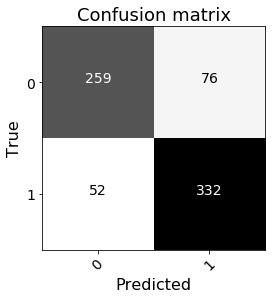

In [76]:
## Train the Model

# clf = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,128,64), random_state=1)
y_true = np.round(df['Score'])

cols = ['word_embedding_ma1','cosine_sim_ma1', 'wm_similarity_ma1','cv_ma1', 'token_dist_ma1', 'length_diff_ma1']

x_train, x_test, y_train, y_test = train_test_split(df_features[cols].as_matrix(), df['Class2_Score'],
                                                    test_size=0.25, random_state=22, stratify=df['Class2_Score'])

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

stats.print_all_stats(y_test, y_pred)
stats.plot_confusion_matrix(stats.cm(y_test, y_pred), classes=np.arange(2))

In [11]:
import os
from gensim.models import KeyedVectors
from gensim.downloader import base_dir

def load_data():
    path = os.path.join(base_dir, 'fasttext-wiki-news-subwords-300', "fasttext-wiki-news-subwords-300.gz")
    model = KeyedVectors.load_word2vec_format(path, binary=False)
    return model

model_en = load_data()

In [130]:
import exp_libs.features as f
import libs.semantics.vsm as vsm
import spacy

nlp_en = spacy.load('en')
pipeline_fn = vsm.create_processing_fn(nlp_en, pp.EN_STOPS)
word2word_fn = vsm.create_word_to_word_similarity_function(model_en)

reload(f)
reload(vsm)

def entailment_similarity(ma, sa):
    
    ma_ng = vsm.create_ngram_list(ma, max_n=1)
    sa_ng = vsm.create_ngram_list(sa, max_n=1)
    
    sim = vsm.entailment_similarity(ma_ng, sa_ng, sim_fn=word2word_fn, length_penalize=False)
    
    return sim

def wmdistance_pipeline(x):
    res = pipeline_fn(x)
    return ' '.join(res)
    
wms_fn = f.create_wmsimilarity(model_en)

count_vec = f.create_count_vectorizer_fn(pipeline_fn, ngram_range=(1,3), stopwords=pp.EN_STOPS)

token_ed = f.create_token_edit_distance(stopwords=pp.EN_STOPS)

feature_map = {
    'word_embedding_ma1' : {
        'column' : 'MA',
        'pipeline_fn' : pipeline_fn,
        'fn' : entailment_similarity
    },
    'cosine_sim_ma1' : {
        'column' : 'MA',
        'pipeline_fn' : lambda x: nlp_en(x),
        'fn' : f.spacy_cosine_similarity
    },
    'wm_similarity_ma1' : {
        'column' : 'MA',
        'pipeline_fn' : wmdistance_pipeline,
        'fn' : wms_fn
    },
    'cv_ma1' : {
        'column' : 'MA',
        'fn' : count_vec
    },
    #'tree_dist_ma1' : {
    #    'column' : 'MA',
    #    'pipeline_fn' : lambda x: nlp_en(x),
    #    'fn' : f.tree_distance,
    #    'norm' : { 'max' : 324, 'min' : 0 } 
    #},
    'token_dist_ma1' : {
        'column' : 'MA',
        'pipeline_fn' : lambda x: nlp_en(x),
        'fn' : token_ed,
        'norm' : { 'max' : 86, 'min' : 0 }
    },
    'length_diff_ma1' : {
        'column' : 'MA',
        'pipeline_fn' : pipeline_fn,
        'fn' : f.length_diff
    }
}

In [81]:
import libs.utils as utils

def grade_student_response(clf, feature_map, ma, sa):
    feature_row = []
    columns = list(feature_map.keys())
    for feature_key, feature_config in feature_map.items():
        feature_fn = feature_config['fn']
        ma_t = ma
        sa_t = sa

        if 'pipeline_fn' in feature_config.keys():
            pipeline_fn = feature_config['pipeline_fn']
            ma_t = pipeline_fn(ma_t)
            sa_t = pipeline_fn(sa_t)
            
        value = feature_fn(ma_t, sa_t)
        
        if feature_key in ['tree_dist_ma1', 'token_dist_ma1']:
            norm = feature_config['norm']
            value = (value - norm['min']) / (norm['max'] - norm['min'])

        feature_row.append(value)
        
    print(columns)
    print(feature_row)
    y_pred = clf.predict([feature_row])
    return y_pred
    



In [88]:
qid = 1.5
prompt = df[df['ID'] == qid].iloc[0]['Prompt']
model_answer = df[df['ID'] == qid].iloc[0]['MA']

student_response = 'variable variable variable'

grade = grade_student_response(clf, feature_map, model_answer, student_response)

print('Prompt: {}'.format(prompt))
print('Model Answer: {}'.format(model_answer))
print('Response: {}'.format(student_response))
print('Grade: {}'.format(grade))

/home/che/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['word_embedding_ma1', 'cosine_sim_ma1', 'wm_similarity_ma1', 'cv_ma1', 'token_dist_ma1', 'length_diff_ma1']
[0.47361040860414505, 0.4129250272582653, 0.7752999622654329, 0.0, 0.046511627906976744, 0.25]
Prompt:  What is a variable? 
Model Answer:  A location in memory that can store a value. 
Response: variable variable variable
Grade: [0]


In [240]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
# K-NN
reload(vsm)

def cosine_coefficient(s1, s2):
    num = len(s1.intersection(s2))
    den = np.sqrt(len(s1)) * np.sqrt(len(s2))
    return num / (den + 1e-30)

def grade_student_response_knn(k, pipeline_fn, student_response, student_responses, scores):

    # (WMD, CV)
    vectors = []
    sr_p = pipeline_fn(student_response)
    
    for sa in student_responses:
        sa_p = pipeline_fn(sa)
        #sa = wmdistance_pipeline(sa)
        #res = wms_fn(sa, student_response)
        v1 = f.spacy_cosine_similarity(nlp_en(sa), nlp_en(student_response))
        #v1 = entailment_similarity(sa_p, sr_p)
        v2 = count_vec(sa, student_response)
        v3 = cosine_coefficient(set(sa_p), set(sr_p))
        vectors.append([v1, v2, v3])
    
    # print(vectors)
    vector_distances = []
    for vec in vectors:
        dist = np.array(vec).dot([0.5, 1.5,1.5])
        #dist = np.sum(vec)
        vector_distances.append(dist)

    results = list(zip(vector_distances, scores))
    results = list(reversed(sorted(results, key=lambda x: x[0])))
    
    top_k = results[:k]
    #print(student_response)
    #print(top_k)
    
    tmp = {}
    
    for item in top_k:
        score = int(item[1])
        if score in tmp:
            tmp[score] += 1
        else:
            tmp[score] = 1
    
    #print(results)
    #print(tmp)
    
    return top_k[0][1]
    
    #max_occur = np.max(list(tmp.values()))
    #if max_occur == 1:
    #    print('Tie: return top result')
    #    
    #else:
    #    for key, value in tmp.items():
    #        if value == max_occur:
    #            print('Returning most occurring: {}'.format(key))
    #            return key
    
#grade_student_response_knn(df, 3, 1.1, df.iloc[0]['SA'], ignore_idx=0)

In [227]:
#grade_student_response_knn(3, pipeline_fn, df.iloc[0]['SA'], df.iloc[1:30]['SA'].tolist(), np.round(df.iloc[1:30]['Score']))

to serve as a proof of concept and illustrate how key problems can be solved.


In [243]:
df2 = data.load_dataframe('../../../datasets/final/en/asag_v2_en_filter.csv')
display(len(df2))
display(df2.head(2))

2010

ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   
1  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   
1   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   
1  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   
1  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   
1  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   
1   To simulate portions of the desired final pro...        5   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1  
1  correct_complete            NaN    5.0             2             1

In [258]:
def test_knn_approach(df, knn=3):
    
    ids = np.unique(df['ID'].values)
    y_pred = []
    y_true = []
    
    counter = 0
    
    for idx in ids:
        section = df[df['ID'] == idx]
        print(idx)
        
        student_responses = section['SA'].values.tolist()
        scores = np.array(section['Score'].values).tolist()
        
        ma1 = section.iloc[0]['MA']
        ma2 = section.iloc[0]['MA2']
        ma3 = section.iloc[0]['MA3']
        na  = section.iloc[0]['NA']
        prompt = section.iloc[0]['Prompt']

        new_values = [(ma1, 5), (ma2,5), (ma3,5), (na, 0), (prompt, 0)]

        for x in new_values:
            student_responses.append(x[0])
            scores.append(x[1])

        scores = np.round(np.array(scores))
        student_responses = np.array(student_responses)
        for k in range(0, len(student_responses)-5):
            sa = student_responses[k]
            sa = str(sa)
            score = scores[k]
            
            mask = np.ones(len(student_responses), dtype=np.bool)
            mask[k] = False
            pred_score = grade_student_response_knn(knn, pipeline_fn, sa, student_responses[mask].tolist(), scores[mask].tolist())
            y_pred.append(pred_score)
            y_true.append(score)
            counter += 1
            
            data.save('./y_pred_raw2', y_pred)
            
            if counter % 10 == 0:
                print('[{}]: finished.'.format(counter))
        
        if counter < 50:
            print('[{}]: done.'.format(counter))
        
    return {
        'y_true_raw' : y_true,
        'y_pred_raw' : y_pred
    }
    
results = test_knn_approach(df2[639:])

4.5


/home/che/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[10]: finished.
[20]: finished.
[21]: done.
5.1
[30]: finished.
[40]: finished.
[49]: done.
5.2
[50]: finished.
[60]: finished.
[70]: finished.
5.3
[80]: finished.
[90]: finished.
[100]: finished.
5.4
[110]: finished.
[120]: finished.
[130]: finished.
6.1
[140]: finished.
[150]: finished.
6.2
[160]: finished.
[170]: finished.
[180]: finished.
6.3
[190]: finished.
[200]: finished.
[210]: finished.
6.4
[220]: finished.
[230]: finished.
6.5
[240]: finished.
[250]: finished.
[260]: finished.
6.6
[270]: finished.
[280]: finished.
6.7
[290]: finished.
[300]: finished.
[310]: finished.
7.1
[320]: finished.
[330]: finished.
[340]: finished.
7.2
[350]: finished.
[360]: finished.
7.3
[370]: finished.
[380]: finished.
[390]: finished.
7.5
[400]: finished.
[410]: finished.
7.6
[420]: finished.
[430]: finished.
[440]: finished.
7.7
[450]: finished.
[460]: finished.
[470]: finished.
8.1
[480]: finished.
[490]: finished.
8.3
[500]: finished.
[510]: finished.
[520]: finished.
8.4
[530]: finished.
[540

In [245]:
y_pred_raw = data.load('./y_pred_raw')

y_true = np.round(df2['Score'].iloc[:len(y_pred_raw)].values

results2 = {}
results2['y_true'] = np.round(y_true).astype(int)
results2['y_pred'] = np.round(y_pred_raw).astype(int)

stats.print_all_stats(results2['y_true'], results2['y_pred'])
stats.plot_confusion_matrix(stats.cm(results2['y_true'], results2['y_pred']), classes=np.arange(6))

SyntaxError: invalid syntax (<ipython-input-245-a9f870bd20af>, line 5)